In [5]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats
import pandas as pd
# from collections import defaultdict

with open('all_rect.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

# Generate the chain results


Generating Connectome...


100%|██████████| 813407/813407 [07:58<00:00, 1700.42it/s]


Generating Connectome...


100%|██████████| 813407/813407 [10:40<00:00, 1269.52it/s]


In [36]:


# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.DiGraph()

import pickle

with open('cell_table.pkl', 'wb') as f:
    pickle.dump(cell_table, f)

with open('post_cell_table.pkl', 'wb') as f:
    pickle.dump(post_cell_table, f)

with open('synapse_table.pkl', 'wb') as f:
    pickle.dump(synapse_table, f)

# Add edges to the graph
rows, cols = data_a['structural']['binary_connectome'].shape
for i in range(rows):
    for j in range(cols):
        if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
            pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=data_a['structural']['binary_connectome'][i, j])

## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)

# Filter the chain results for chains from an excitatory cell to an inhibitory cell to an excitatory cell
# filtered_chain_results = []
# for chain in chain_results:
#     if cell_table.iloc[chain['A'].split('_')[1]]. and cell_table.iloc[chain['A'].split('_')[1]] chain['C'].split('_')[0] == 'post':
#         filtered_chain_results.append(chain)


two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
removed_pre_post_strings = np.zeros_like(two_chain_results_array)
for i, c in enumerate(chain_results):
    for j, n in enumerate(c.values()):
        removed_pre_post_strings[i, j] = int(n.split('_')[1])

two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

# two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

assembly_chain_results_arrays = [two_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids


0it [00:34, ?it/s]
0it [00:00, ?it/s]


In [39]:
# Prep the sets

# Collect w and s
w = {}
s = {}
for pre in pre_root_ids:
    for post in post_root_ids:
        w[(pre, post)] = 0
        s[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids}
no_A = set(assembly_to_root_ids['No A'])

# C functions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def between(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, between, shared_no_a, no_a_a, a_no_a]


shared


In [44]:

# Calculate the weighted summed values

W_out = {}
for c in C:
    W_out[c.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            W_out[c.__name__][j] = sum([w[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])
    
W_in = {}
for c in C:
    W_in[c.__name__] = {}
    for i in post_root_ids:
        if len([j for j in post_root_ids if c(j, i, A)]) > 0:
            W_in[c.__name__][j] = sum([w[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

print(W_out)

{'shared': {864691132807412738: 0.0, 864691132748334211: 108.54545454545455, 864691132853487363: 114.57142857142857, 864691132841768198: 382.75757575757575, 864691132834513288: 0.0, 864691132834925960: 0.0, 864691132636193294: 0.0, 864691132721900430: 37.6875, 864691132771662867: 144.2, 864691132578187284: 0.0, 864691132835126165: 109.60606060606061, 864691132577861908: 0.0, 864691132734110231: 0.0, 864691132734110999: 8.083333333333334, 864691132741334425: 15.333333333333334, 864691132738257819: 81.48936170212765, 864691132678493470: 0.0, 864691132770059681: 0.0, 864691132741590308: 115.94545454545455, 864691132641639590: 0.0, 864691132635895079: 398.0952380952381, 864691132660826793: 0.0, 864691132720041642: 0.0, 864691132604748205: 51.794117647058826, 864691132731808307: 0.0, 864691132841658548: 0.0, 864691132972662837: 0.0, 864691132999886005: 10.818181818181818, 864691132595467831: 0.0, 864691132728579766: 0.0, 864691132573738810: 0.0, 864691132851739966: 91.66666666666667, 864691



OUTBOUND SUMMED PSDS

shared vs between
Greater:
RanksumsResult(statistic=-1.6708915255217223, pvalue=0.9526284471457166)
Lesser:
RanksumsResult(statistic=-1.6708915255217223, pvalue=0.04737155285428341)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.48237658087369983, pvalue=0.3147692272636218)
Lesser:
RanksumsResult(statistic=0.48237658087369983, pvalue=0.6852307727363782)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.997456658755786, pvalue=0.8407285493417638)
Lesser:
RanksumsResult(statistic=-0.997456658755786, pvalue=0.15927145065823617)

shared vs a_no_a
Greater:
RanksumsResult(statistic=1.1561920527249316, pvalue=0.12380130489867613)
Lesser:
RanksumsResult(statistic=1.1561920527249316, pvalue=0.8761986951013239)

between vs shared
Greater:
RanksumsResult(statistic=1.6708915255217223, pvalue=0.04737155285428341)
Lesser:
RanksumsResult(statistic=1.6708915255217223, pvalue=0.9526284471457166)

between vs shared_no_a
Greater:
RanksumsResult(statistic=1.5043608

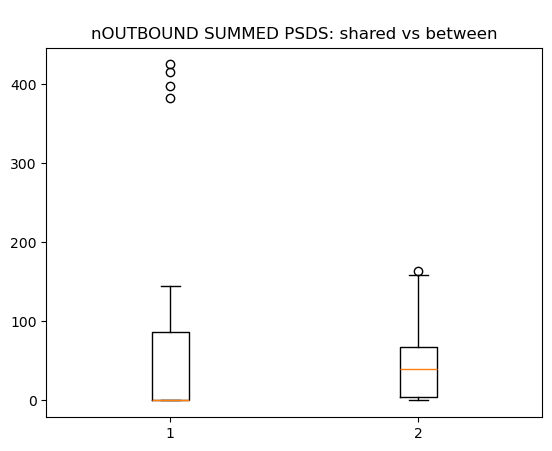

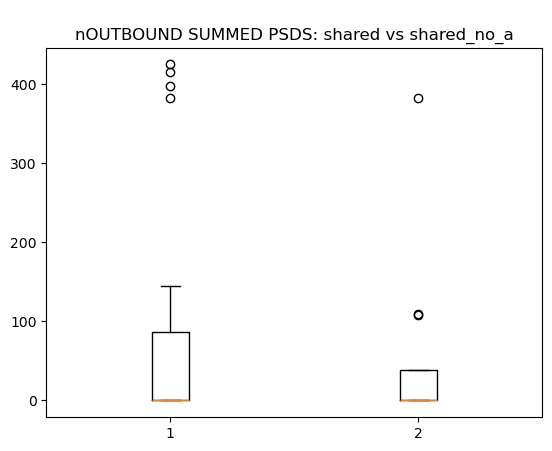

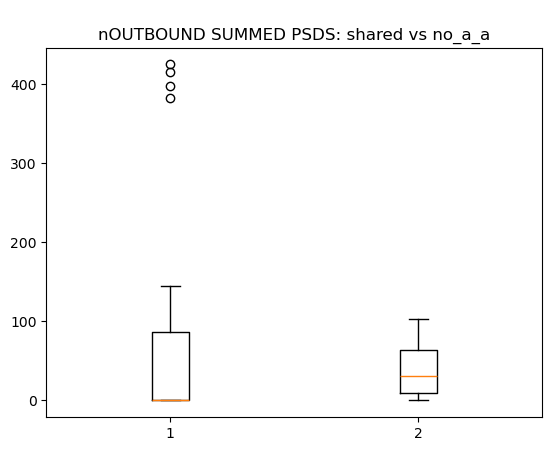

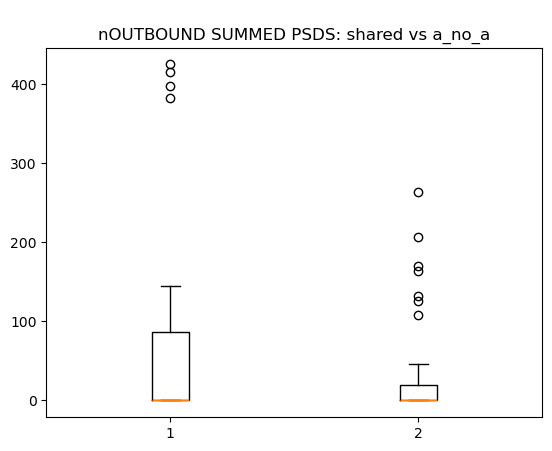

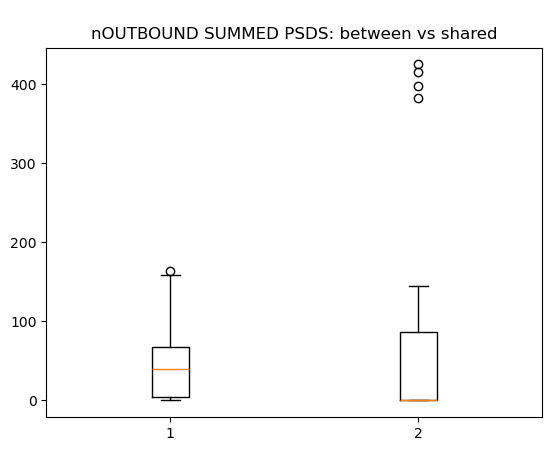

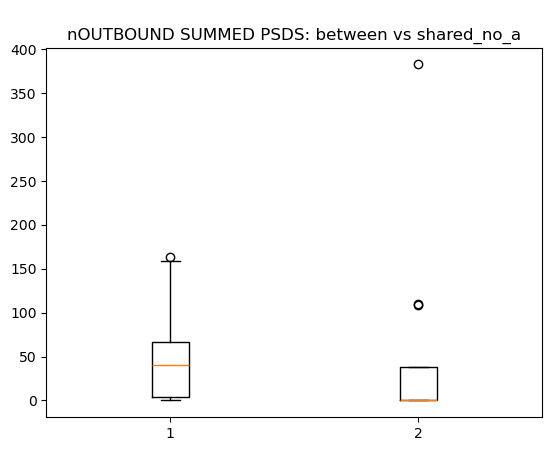

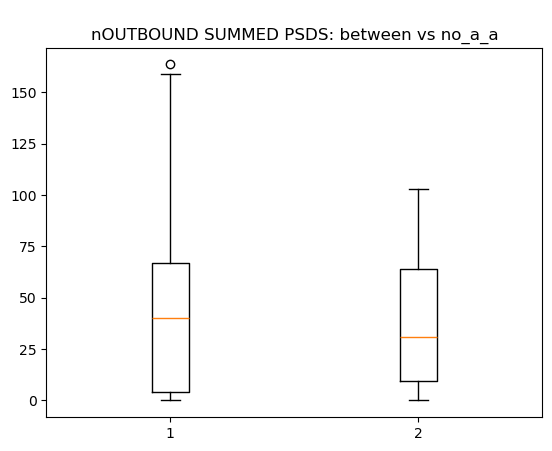

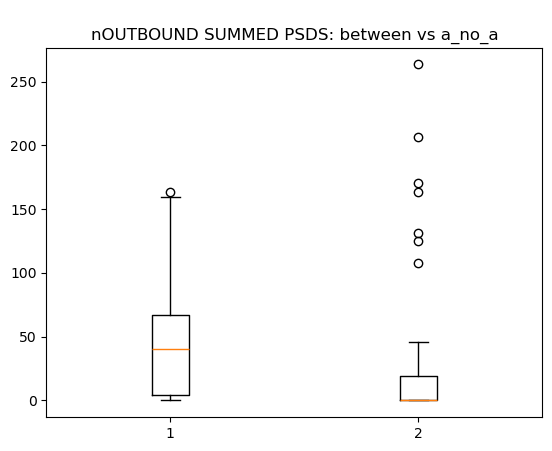

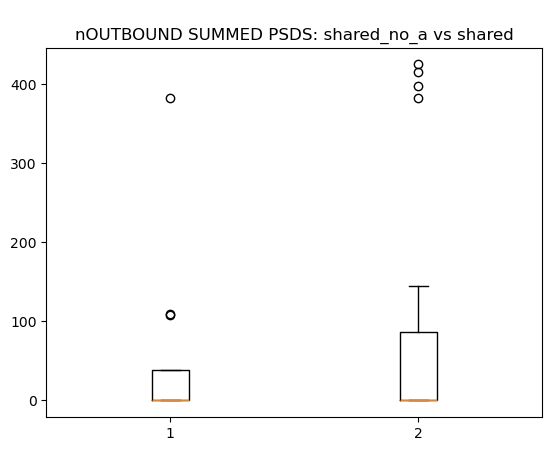

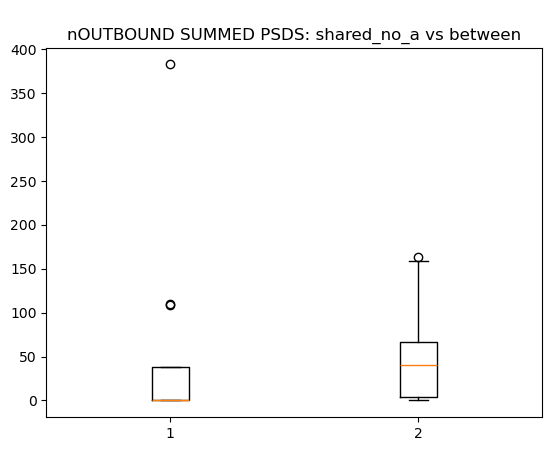

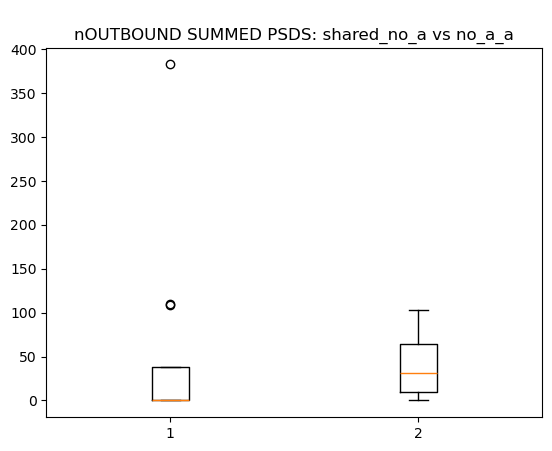

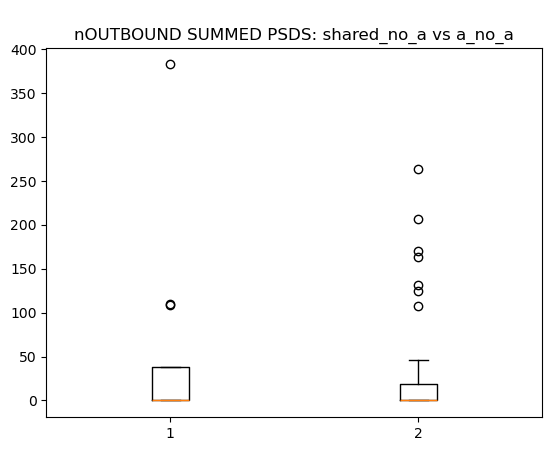

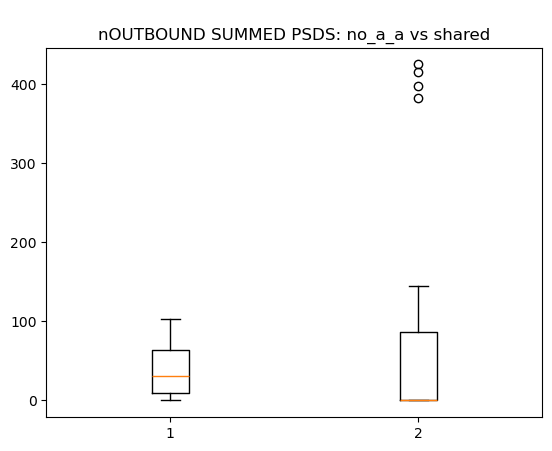

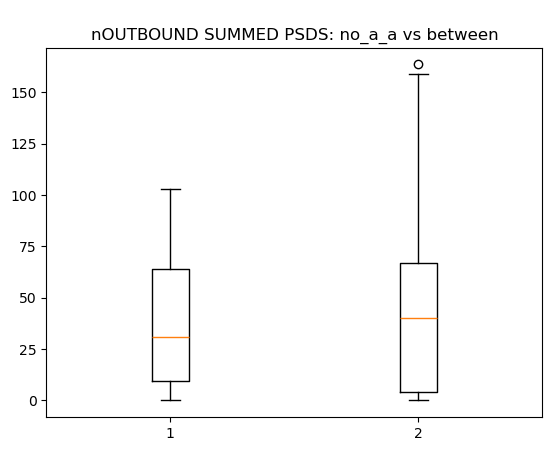

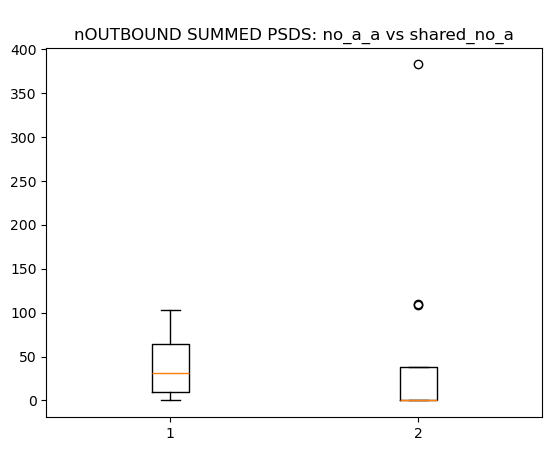

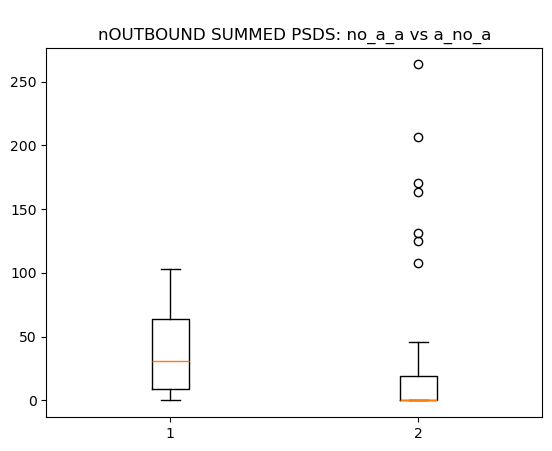

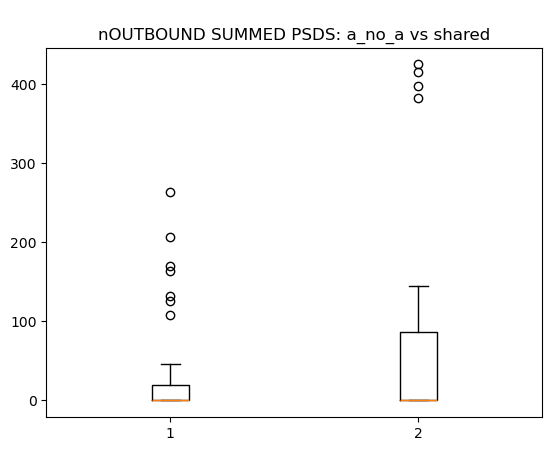

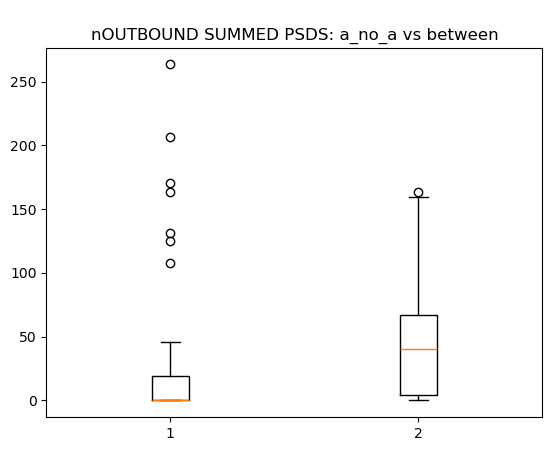

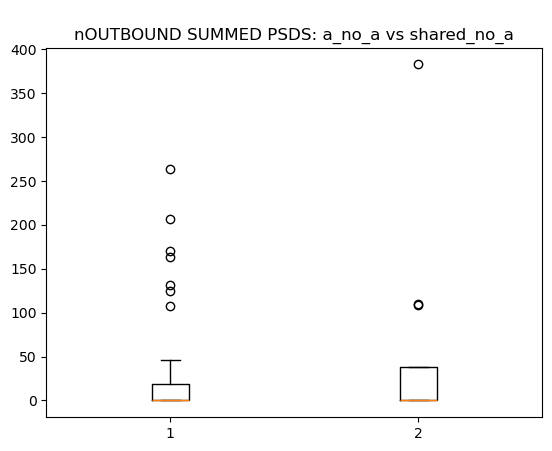

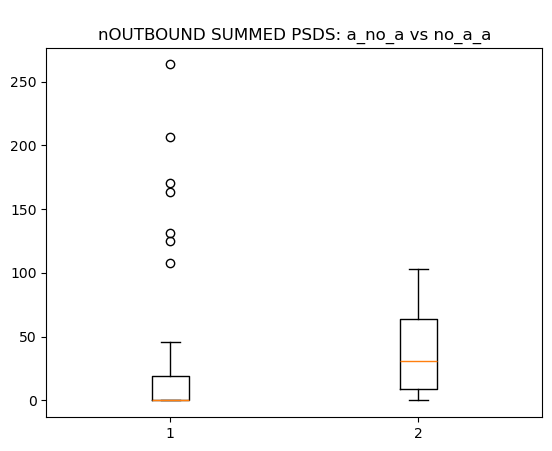

In [48]:
# Outbound Statistical tests

print('\n\nOUTBOUND SUMMED PSDS')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            print('Greater:')
            print(stats.ranksums(list(W_out[c1.__name__].values()), list(W_out[c2.__name__].values()), alternative='greater'))
            plt.figure()
            plt.boxplot([list(W_out[c1.__name__].values()), list(W_out[c2.__name__].values())])
            plt.title(f'\nnOUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



INBOUND SUMMED PSDS

shared vs between
Greater:
RanksumsResult(statistic=-1.6708915255217223, pvalue=0.9526284471457166)
Lesser:
RanksumsResult(statistic=-1.6708915255217223, pvalue=0.04737155285428341)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.48237658087369983, pvalue=0.3147692272636218)
Lesser:
RanksumsResult(statistic=0.48237658087369983, pvalue=0.6852307727363782)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.997456658755786, pvalue=0.8407285493417638)
Lesser:
RanksumsResult(statistic=-0.997456658755786, pvalue=0.15927145065823617)

shared vs a_no_a
Greater:
RanksumsResult(statistic=1.1561920527249316, pvalue=0.12380130489867613)
Lesser:
RanksumsResult(statistic=1.1561920527249316, pvalue=0.8761986951013239)

between vs shared
Greater:
RanksumsResult(statistic=1.6708915255217223, pvalue=0.04737155285428341)
Lesser:
RanksumsResult(statistic=1.6708915255217223, pvalue=0.9526284471457166)

between vs shared_no_a
Greater:
RanksumsResult(statistic=1.50436086

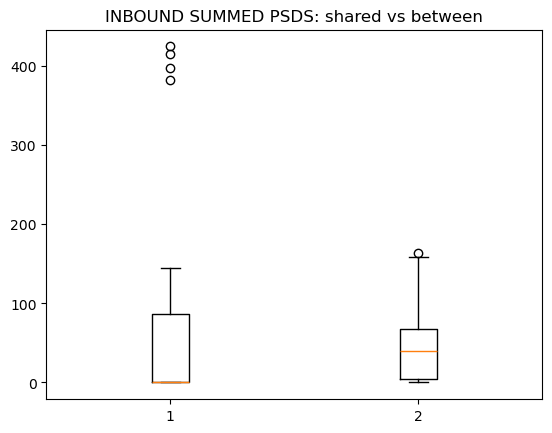

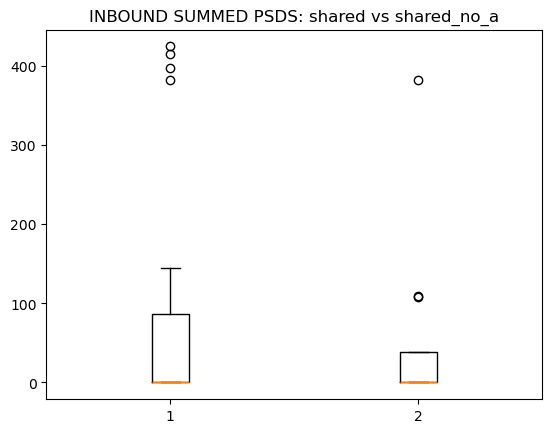

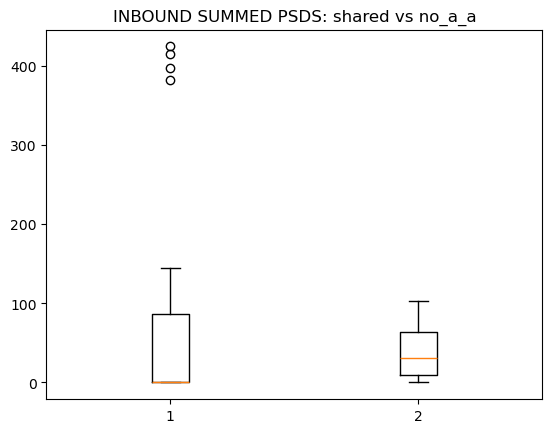

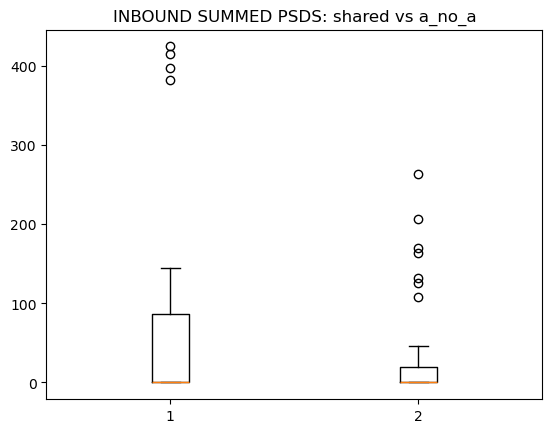

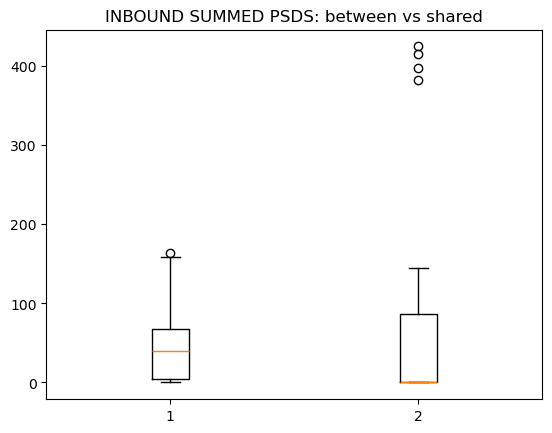

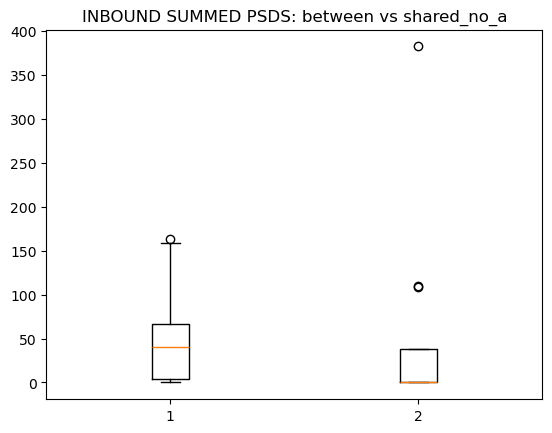

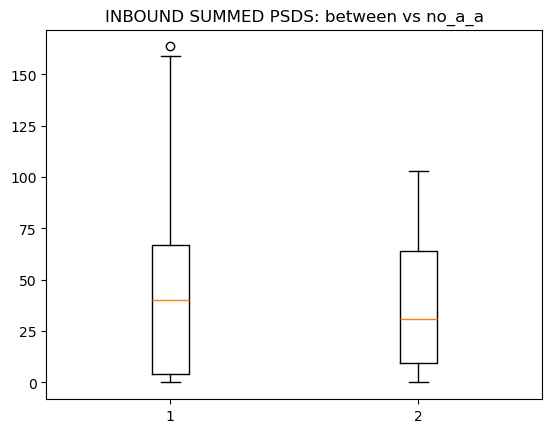

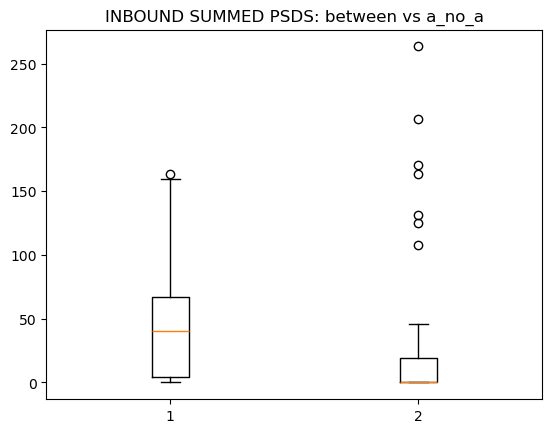

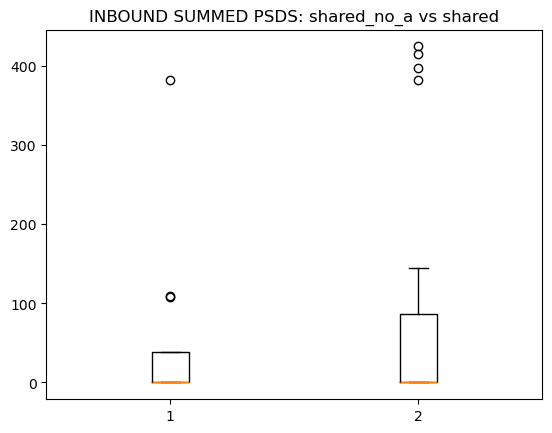

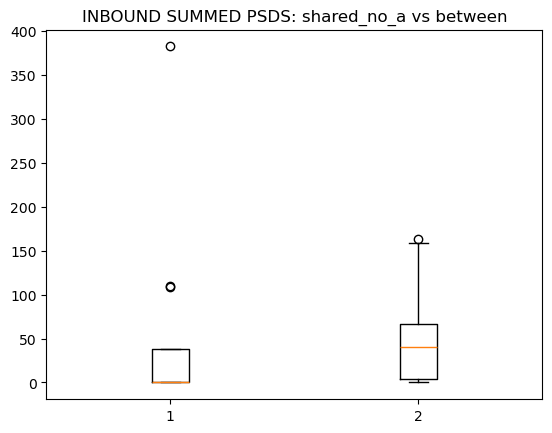

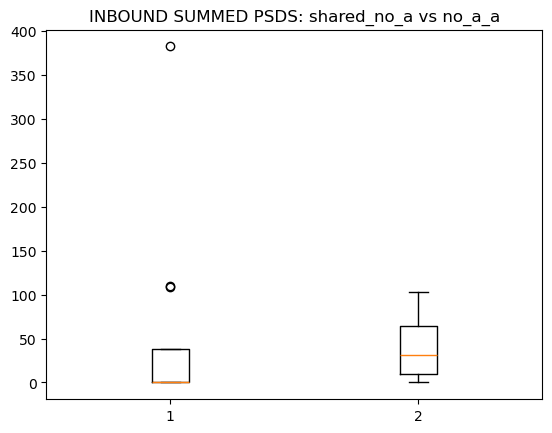

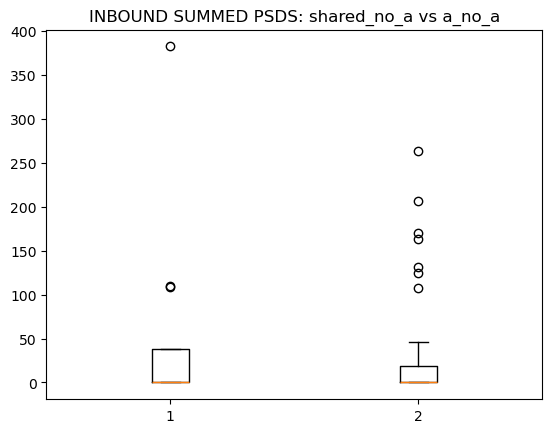

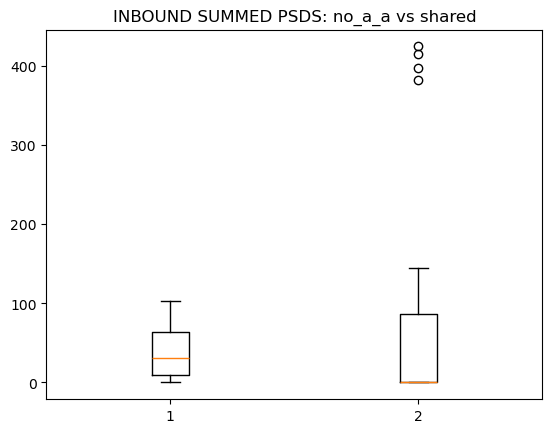

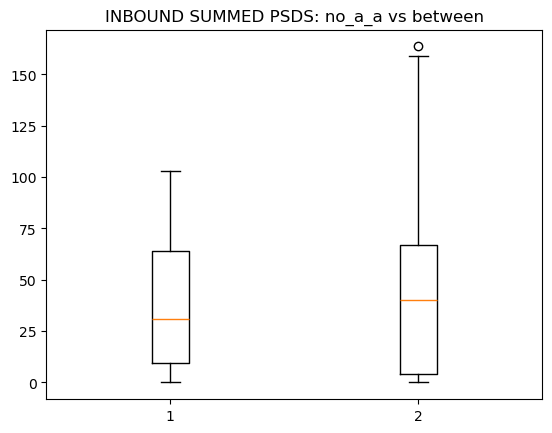

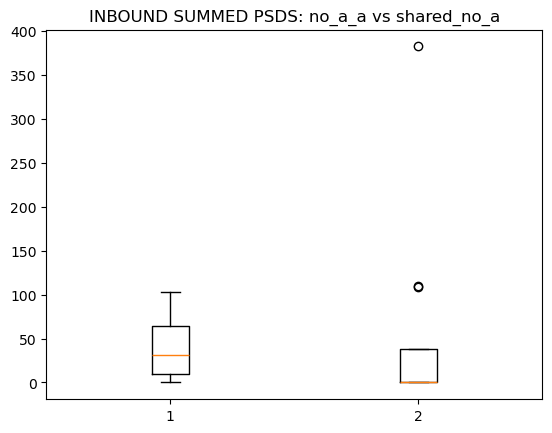

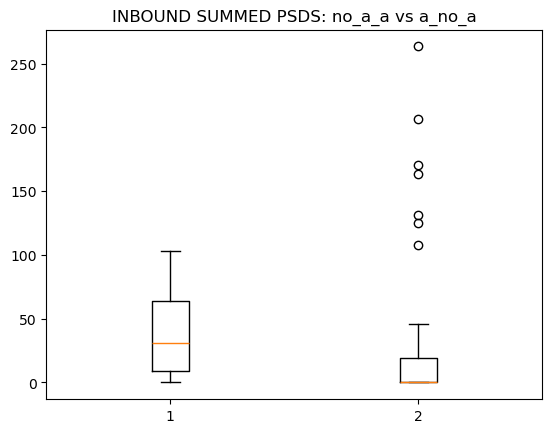

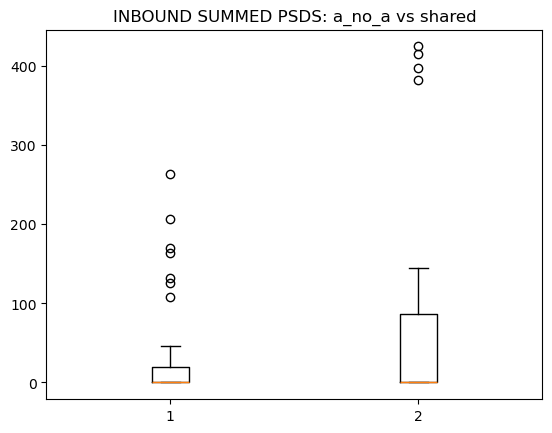

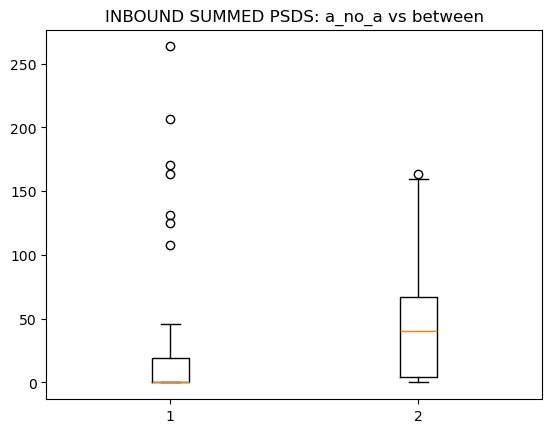

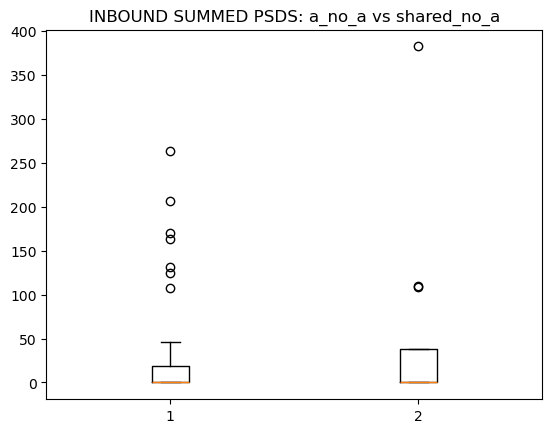

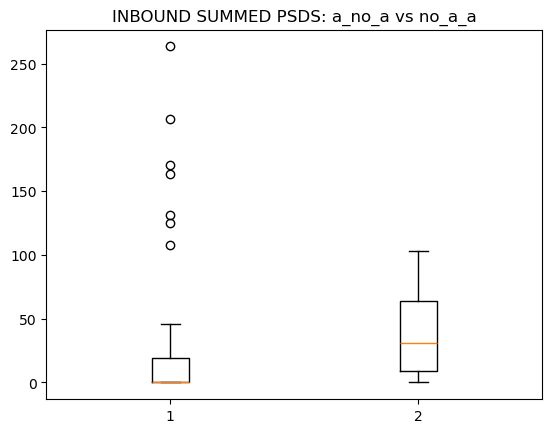

In [51]:
# Inbound Statistical tests

print('\n\nINBOUND SUMMED PSDS')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            print('Greater:')
            print(stats.ranksums(list(W_in[c1.__name__].values()), list(W_in[c2.__name__].values()), alternative='greater'))
            plt.figure()
            plt.boxplot([list(W_in[c1.__name__].values()), list(W_in[c2.__name__].values())])
            plt.title(f'INBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')